# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

import matplotlib
import os

from datetime import datetime
from tqdm import tqdm
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from definitions import ROOT_DIR
from micro_price.ImbalancePriceDeltaMicroPrice import ImbalancePriceDeltaMicroPrice
from orderbook_aggregator.ImbalancePriceDeltaAggregator import ImbalancePriceDeltaAggregator

# Set font

In [2]:
matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

# Global variables

In [3]:
csco_ticker = "CSCO"
csco_levels = 5
csco_start_date = datetime(2019,1,1)
csco_end_date = datetime(2019,1,31)

bac_ticker = "BAC"
bac_levels = 10
bac_start_date = datetime(2019,11,1)
bac_end_date = datetime(2019,11,29)

# Load and process order book data

In [4]:
csco_orderbooks: List[ImbalancePriceDeltaAggregator] = []
for d in tqdm(pd.date_range(csco_start_date, csco_end_date)):
    try:
        csco_orderbooks.append(ImbalancePriceDeltaAggregator(d, csco_ticker, csco_levels, spread_size=100))
    except FileNotFoundError:
        continue
        
csco_microprice = ImbalancePriceDeltaMicroPrice(csco_orderbooks)

100%|██████████| 31/31 [31:27<00:00, 60.90s/it]


In [5]:
bac_orderbooks: List[ImbalancePriceDeltaAggregator] = []
for d in tqdm(pd.date_range(bac_start_date, bac_end_date)):
    try:
        bac_orderbooks.append(ImbalancePriceDeltaAggregator(d, bac_ticker, bac_levels, spread_size=100))
    except FileNotFoundError:
        continue
        
bac_microprice = ImbalancePriceDeltaMicroPrice(bac_orderbooks)

100%|██████████| 29/29 [18:00<00:00, 37.27s/it]


# Calculate micro-price

In [6]:
csco_microprice_df = csco_microprice.calculate_micro_price()

In [7]:
csco_microprice_df.stack().to_csv(os.path.join(ROOT_DIR, "models", "csco_micro_price.csv"))

In [8]:
bac_microprice_df = bac_microprice.calculate_micro_price()

In [9]:
bac_microprice_df.stack().to_csv(os.path.join(ROOT_DIR, "models", "bac_micro_price.csv"))

# Plot micro-price

In [10]:
csco_example_plot = csco_orderbooks[0].orderbook.iloc[14000:17000].copy()
csco_example_micro_prices = [
    csco_microprice_df.loc[imbalance, mid_price_delta] 
    for imbalance, mid_price_delta in zip(csco_example_plot["imbalance"], csco_example_plot["mid_price_delta"])
]
csco_example_plot["micro_price"] = csco_example_micro_prices

bac_example_plot = bac_orderbooks[0].orderbook.iloc[14000:17000].copy()
bac_example_micro_prices = [
    bac_microprice_df.loc[imbalance, mid_price_delta] 
    for imbalance, mid_price_delta in zip(bac_example_plot["imbalance"], bac_example_plot["mid_price_delta"])
]
bac_example_plot["micro_price"] = bac_example_micro_prices

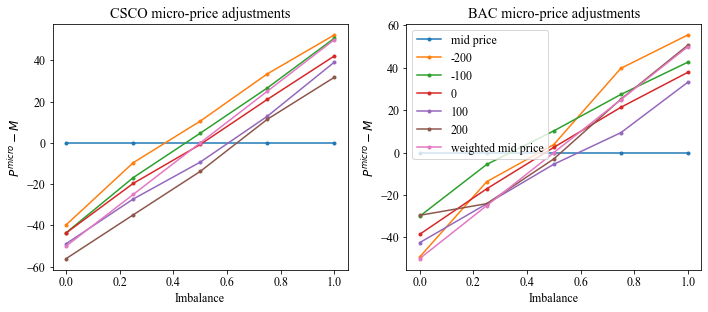

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,4.5))

ax[0].plot(csco_microprice_df.index, np.repeat(0,len(csco_microprice_df.index)), ".-")
ax[0].plot(csco_microprice_df, ".-")
ax[0].plot(csco_microprice_df.index, np.linspace(-50,50,len(csco_microprice_df.index)), ".-")
ax[0].set_xlabel("Imbalance")
ax[0].set_ylabel("$P^{micro} - M$")
ax[0].set_title("CSCO micro-price adjustments")

ax[1].plot(bac_microprice_df.index, np.repeat(0,len(bac_microprice_df.index)), ".-")
ax[1].plot(bac_microprice_df, ".-")
ax[1].plot(bac_microprice_df.index, np.linspace(-50,50,len(bac_microprice_df.index)), ".-")
ax[1].set_xlabel("Imbalance")
ax[1].set_ylabel("$P^{micro} - M$")
ax[1].set_title("BAC micro-price adjustments")
ax[1].legend(["mid price"] + list(bac_microprice_df.columns) + ["weighted mid price"], loc="upper left")

fig.tight_layout()

plt.show()

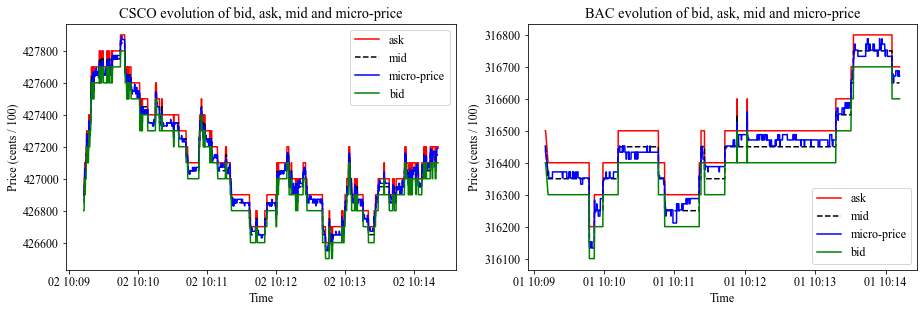

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4.5))

ax[0].plot(csco_example_plot["ask_price_0"], "r")
ax[0].plot(csco_example_plot["mid_price"], "k--")
ax[0].plot(csco_example_plot["mid_price"] + csco_example_plot["micro_price"], "b")
ax[0].plot(csco_example_plot["bid_price_0"], "g")
ax[0].set_title("CSCO evolution of bid, ask, mid and micro-price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Price (cents / 100)")
ax[0].legend(["ask", "mid", "micro-price", "bid"], loc="upper right")

ax[1].plot(bac_example_plot["ask_price_0"], "r")
ax[1].plot(bac_example_plot["mid_price"], "k--")
ax[1].plot(bac_example_plot["mid_price"] + bac_example_plot["micro_price"], "b")
ax[1].plot(bac_example_plot["bid_price_0"], "g")
ax[1].set_title("BAC evolution of bid, ask, mid and micro-price")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Price (cents / 100)")
ax[1].legend(["ask", "mid", "micro-price", "bid"], loc="lower right")

fig.tight_layout()

plt.show()